Look at relations between CIB at different frequencies

In [1]:
#Plots
import pickle
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
import os
#os.environ['DISABLE_MPI']="true"
from os.path import join as opj
import numpy as np
#from solenspipe import weighted_bin1D
#from prepare_websky_map import safe_mkdir
import healpy as hp

In [2]:
freqs = ["0095", "0145", "0545"]
smoothing_scales = [1., 5., 20.] #arcmin

In [3]:
websky_dir = "/global/cscratch1/sd/maccrann/cmb/websky/"
CONVERSION_FACTORS = {"CIB" : 
                      {"0093" : 4.6831e3, "0100" : 4.1877e3, "0145" : 2.6320e3, "0545" : 1.7508e4},
                      "Y" : 
                      {"0093" : -4.2840e6, "0100": -4.1103e6, "0145" : -2.8355e6},
}

In [4]:
cib_145 = hp.read_map(opj(websky_dir, "cib_nu0145.fits"))
t_145 = cib_145*CONVERSION_FACTORS["CIB"]["0145"]
cib_545 = hp.read_map(opj(websky_dir, "cib_nu0545.fits"))
t_545 = cib_545*CONVERSION_FACTORS["CIB"]["0545"]

/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 4096
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))

In [14]:
def get_mask(cib_map, flux_threshold):
    #cib_map is flux density in MJy
    return cib_map * 1.e9 * hp.nside2pixarea(4096) < flux_threshold

In [10]:
fracs = np.logspace(-5,-2,5)
flux_thresholds_145 = []
flux_thresholds_545 = []
frac_high_masked = []
for frac in fracs:
    t_145 = np.percentile(cib_145, (1-frac)*100)
    t_545 = np.percentile(cib_545, (1-frac)*100)
    flux_thresholds_145.append(t_145 * 1.e9 * hp.nside2pixarea(4096))
    flux_thresholds_545.append(t_545 * 1.e9 * hp.nside2pixarea(4096))
    mask_145 = cib_145 < t_145
    mask_545 = cib_545 < t_545
    frac_high_masked.append(float(((~mask_545) & (~mask_145)).sum())/(~mask_545).sum())
    #frac_545_masked_by_145 = float(((~mask_545) & (~mask_145)).sum())/(~mask_545).sum()
    #frac_145_masked_by_545 = float(((~mask_145) & (~mask_545)).sum())/(~mask_145).sum()
    #print(frac_545_masked_by_145)
    #print(frac_145_masked_by_545)

In [11]:
print(flux_thresholds_145)
print(flux_thresholds_545)

[16.086520602682437, 6.523766298640471, 2.8082209797772837, 1.9343742261117038, 1.5078847263040362]
[1085.318250945172, 426.7570846062674, 165.99489263371012, 81.12887092445219, 56.417418315498516]


In [16]:
flux_thresholds_545 = np.linspace(50,1000,10)
frac_high_545 = []
frac_high_masked_145 = []
for f in flux_thresholds_545:
    mask_545 = get_mask(cib_545, f)
    f_545 = float((~mask_545).sum())/len(mask_545)
    frac_high_545.append(f_545)
    percentile_145 = np.percentile(cib_145, (1-f_545)*100)
    high_145 = cib_145 > percentile_145
    f_145 = float((high_145 & (~mask_545)).sum()) / (high_145).sum()
    print(np.log10(f_545), f_145)
    frac_high_masked_145.append(f_145)

-1.7122558595817716 0.4613678416928325
-3.4433774767716954 0.589472087796942
-3.862520257066662 0.6368440101339125
-4.130685727268288 0.6411650224817126
-4.335184764516388 0.6465341214400859
-4.505112428031924 0.6466942148760331
-4.635981456665812 0.645327604726101
-4.750139443593169 0.639843531712769
-4.848447173204545 0.6450595655220743
-4.937478184757201 0.6425806451612903


Text(0, 0.5, 'fraction of the $f_{545}$ pixels masked at 145GHz')

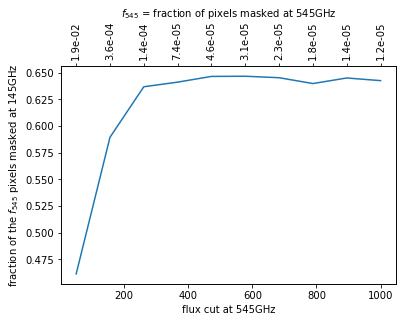

In [31]:
%matplotlib inline
fig,ax = plt.subplots()

frac_high_545 = np.array(frac_high_545)

ax.plot(flux_thresholds_545, frac_high_masked_145)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(flux_thresholds_545)
ax2.set_xticklabels( ["%.1e"%f for f in  frac_high_545], rotation=90)
ax.set_xlabel("flux cut at 545GHz")
ax2.set_xlabel(r"$f_{545}$ = fraction of pixels masked at 545GHz")
ax.set_ylabel(r"fraction of the $f_{545}$ pixels masked at 145GHz")

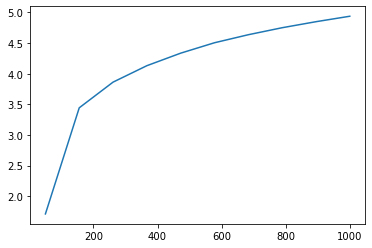

In [20]:
%matplotlib inline
fig,ax = plt.subplots()
ax.plot(flux_thresholds_545, -np.log10(frac_high_545))

In [18]:
lmax=2000
mask_thresh_145 = 7.
mask_thresh_545 = 350.

cib_mask_145 = get_mask(cib_145, mask_thresh_145)
cib_mask_545 = get_mask(cib_545, mask_thresh_545)

In [6]:
def get_rl(map1, map2, lmax, mask=None, sub_mean=True):
    if mask is None:
        mask = np.ones_like(map1)
    map1 = map1 - map1.mean()
    map2 = map2 - map2.mean()
    cl11 = hp.anafast(map1*mask, lmax=lmax)
    cl22 = hp.anafast(map2*mask, lmax=lmax)
    return hp.anafast(map1*mask, map2*mask, lmax=lmax) / np.sqrt(cl11*cl22)

In [ ]:
rl_nomask = get_rl(t_145, t_545, lmax)
rl_mask_145 = get_rl(t_145, t_545, lmax, mask=cib_mask_145)
rl_mask_545 = get_rl(t_145, t_545, lmax, mask=cib_mask_545)

In [ ]:
%matplotlib inline
fig,ax = plt.subplots()
ells = np.arange(lmax+1)
ax.plot(ells, rl_nomask, label='no mask')
ax.plot(ells, rl_mask_145, label='>%d mJY at 145GHz masked'%mask_thresh_145)
ax.plot(ells, rl_mask_545, label='>%d mJY at 545GHz masked'%mask_thresh_545)
ax.set_xlabel("L")
ax.set_ylabel("C_L^{12} / \sqrt{C_L^{11}C_L{22}}")